In [1]:
# packages for dealing with Sidra API
import requests
import json

# packages for treating the data
import pandas as pd
import pandana as pdna
import numpy as np
import unidecode

# packages for dealing with geographical data
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import osmnx as ox
from osmnx.distance import get_nearest_node

To hide the warning that says "`should_run_async` will not call `transform_cell` automatically in the future", we use the code below while the [issue](https://github.com/ipython/ipykernel/issues/540) isn't solved.

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

## Building the dataset

This project aims to measure the pedestrian acessibility in Natal, Brazil. With that in mind, we use data from [Sidra API](http://api.sidra.ibge.gov.br/) regarding the neighborhoods, average income and population size. Further, we calculate the smallest distance from a central point of the neighborhood to an amenity. All this informations togheter will become our dataset.

In [3]:
# Recover income by neighborhood in Natal (2010)
# from Sidra's Table 3170 (http://api.sidra.ibge.gov.br/desctabapi.aspx?c=3170)
headers = {
    'Content-Type': 'application/json;charset=UTF-8',
    'User-Agent': 'google-colab',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7',
    'Connection': 'keep-alive',
}

endnode = "http://api.sidra.ibge.gov.br/values/t/3170/p/2010/v/842/N102/in%20n6%202408102"
response = requests.get(endnode,headers=headers)
raw_data_income = response.json()

In [4]:
# Recover the number of inhabitants
endnode_people = "http://api.sidra.ibge.gov.br/values/t/3170/p/2010/v/841/N102/in%20n6%202408102"
response = requests.get(endnode_people,headers=headers)
raw_data_people = response.json()

The variables 842 and 841 give us, respectivelly, the information about income and population of each neighborhood. Now we take a look at the responses to find out the meaning of each key-value pair.

In [5]:
raw_data_income[0]

{'NC': 'Nível Territorial (Código)',
 'NN': 'Nível Territorial',
 'MC': 'Unidade de Medida (Código)',
 'MN': 'Unidade de Medida',
 'V': 'Valor',
 'D1C': 'Ano (Código)',
 'D1N': 'Ano',
 'D2C': 'Variável (Código)',
 'D2N': 'Variável',
 'D3C': 'Bairro (Código)',
 'D3N': 'Bairro',
 'D4C': 'Situação do domicílio (Código)',
 'D4N': 'Situação do domicílio',
 'D5C': 'Sexo (Código)',
 'D5N': 'Sexo',
 'D6C': 'Grupo de idade (Código)',
 'D6N': 'Grupo de idade'}

In [6]:
raw_data_people[0]

{'NC': 'Nível Territorial (Código)',
 'NN': 'Nível Territorial',
 'MC': 'Unidade de Medida (Código)',
 'MN': 'Unidade de Medida',
 'V': 'Valor',
 'D1C': 'Ano (Código)',
 'D1N': 'Ano',
 'D2C': 'Variável (Código)',
 'D2N': 'Variável',
 'D3C': 'Bairro (Código)',
 'D3N': 'Bairro',
 'D4C': 'Situação do domicílio (Código)',
 'D4N': 'Situação do domicílio',
 'D5C': 'Sexo (Código)',
 'D5N': 'Sexo',
 'D6C': 'Grupo de idade (Código)',
 'D6N': 'Grupo de idade'}

The keys for neighborhood code, neighborhood name, and value for each variable (income and population), are, in this order, `D3C`, `D3N` and `V`. We use these to build the first dataframes. Only the dataset for income will have the name, because the two datasets will be merged using the neighboorhood code.

In [7]:
# create a dataset for each json
income_df = pd.DataFrame(raw_data_income, columns=['D3C', 'D3N', 'V'])
income_df.drop(labels=0, inplace=True)

people_df = pd.DataFrame(raw_data_people, columns=['D3C', 'V'])
people_df.drop(labels=0, inplace=True)

In [8]:
# quick checkout on the results
print(income_df.head())
print(people_df.head())

          D3C                         D3N        V
1  2408102001    Santos Reis - Natal - RN   984.31
2  2408102002  Praia do Meio - Natal - RN  1658.16
3  2408102003          Rocas - Natal - RN   969.39
4  2408102004        Ribeira - Natal - RN  2825.82
5  2408102005     Petrópolis - Natal - RN  4736.63
          D3C     V
1  2408102001  2989
2  2408102002  2810
3  2408102003  5806
4  2408102004  1453
5  2408102005  3288


In [9]:
neighborhood_df = income_df.merge(people_df, on='D3C')
neighborhood_df.head()

D3C                         D3N      V_x   V_y
0  2408102001    Santos Reis - Natal - RN   984.31  2989
1  2408102002  Praia do Meio - Natal - RN  1658.16  2810
2  2408102003          Rocas - Natal - RN   969.39  5806
3  2408102004        Ribeira - Natal - RN  2825.82  1453
4  2408102005     Petrópolis - Natal - RN  4736.63  3288

Finally, the columns will be renamed. There is a need to remove any accents from the names of the neighborhoods. This is necessary to enable the merge with the geojson data, that only has names, not codes for identifying the regions. Also, the redundant "- Natal - RN" must be removed too.

In [10]:
new_columns = {'V_x':'income', 'D3C':'id', 'D3N':'name', 'V_y':'inhabitants'}
neighborhood_df.rename(columns=new_columns, inplace=True)

# normalize the names
neighborhood_df['name'] = neighborhood_df.name.str.split(pat=' - ', n=1, expand=True)[0]
neighborhood_df['name_norm'] = neighborhood_df.name.apply(lambda x:unidecode.unidecode(x))

In [11]:
neighborhood_df.head()

id           name   income inhabitants      name_norm
0  2408102001    Santos Reis   984.31        2989    Santos Reis
1  2408102002  Praia do Meio  1658.16        2810  Praia do Meio
2  2408102003          Rocas   969.39        5806          Rocas
3  2408102004        Ribeira  2825.82        1453        Ribeira
4  2408102005     Petrópolis  4736.63        3288     Petropolis

Last but not least, we will add the administrative regions or zones, as they are known, to which the districts belong to the Ordinary Law nº 03878/89 of the municipality of Natal. This information was previously inserted into a JSON file

In [12]:
with open('../data/interim/zones.json') as fp:
    zones = json.load(fp)
neighborhood_df['zone'] = neighborhood_df['name'].map(zones) 

In [13]:
neighborhood_df.head()

id           name   income inhabitants      name_norm  zone
0  2408102001    Santos Reis   984.31        2989    Santos Reis  East
1  2408102002  Praia do Meio  1658.16        2810  Praia do Meio  East
2  2408102003          Rocas   969.39        5806          Rocas  East
3  2408102004        Ribeira  2825.82        1453        Ribeira  East
4  2408102005     Petrópolis  4736.63        3288     Petropolis  East

### Retrieving the centroid of each neighborhood
The GeoJSON file provides a polygon that describes Natal geographically. If we get its central point, which means its centroid, we can measure the distance between the center of the area and a point of interest as school, bank, police station, etc. [geopandas](http://geopandas.org/) module is responsible for dealing with this data.

In [14]:
# load the GeoJSON data and use 'UTF-8'encoding
geojson_natal_file = requests.get('https://github.com/nymarya/data-science-one/blob/master/Lesson%2314/natal.geojson?raw=true')
geo_json_natal = geojson_natal_file.json()

In [15]:
# save it in a local file
with open('../data/external/natal.geojson', 'w') as file:  
    json.dump(geo_json_natal, file)
    
geojson_df = gpd.read_file("../data/external/natal.geojson")

Let's make sure that the data is all there

In [16]:
geojson_df.head()

id               @id admin_level        boundary  is_in  \
0   relation/388146   relation/388146          10  administrative  Natal   
1   relation/388147   relation/388147          10  administrative  Natal   
2   relation/397022   relation/397022          10  administrative  Natal   
3  relation/1230018  relation/1230018          10  administrative  Natal   
4  relation/1230020  relation/1230020          10  administrative  Natal   

          name   place      type alt_name wikidata  \
0      Pitimbu  suburb  boundary     None     None   
1     Planalto  suburb  boundary     None     None   
2  Ponta Negra  suburb  boundary     None     None   
3     Neópolis  suburb  boundary     None     None   
4  Capim Macio  suburb  boundary     None     None   

                                            geometry  
0  POLYGON ((-35.24373 -5.84203, -35.24379 -5.842...  
1  POLYGON ((-35.25382 -5.86629, -35.25361 -5.866...  
2  POLYGON ((-35.18902 -5.89079, -35.18895 -5.890...  
3  POLYGON ((-35.20031 -5.87341, -35.19996 -5.873...  
4  POLYGON ((-35.18946 -5.87242, -35.18907 -5.871...

In [17]:
geojson_df.name.unique()

array(['Pitimbu', 'Planalto', 'Ponta Negra', 'Neópolis', 'Capim Macio',
       'Lagoa Azul', 'Pajuçara', 'Lagoa Seca', 'Barro Vermelho',
       'Candelária', 'Praia do Meio', 'Rocas', 'Santos Reis', 'Redinha',
       'Salinas', 'Igapó', 'Nossa Senhora da Apresentação', 'Potengi',
       'Ribeira', 'Cidade Alta', 'Alecrim', 'Nordeste', 'Quintas',
       'Bom Pastor', 'Dix-Sept Rosado', 'Nossa Senhora de Nazaré',
       'Lagoa Nova', 'Mãe Luiza', 'Nova Descoberta', 'Tirol',
       'Petrópolis', 'Areia Preta', 'Cidade Nova', 'Cidade da Esperança',
       'Felipe Camarão', 'Guarapes'], dtype=object)

In [18]:
n_neighborhoods1 = len(neighborhood_df.name.unique())
n_neighborhoods2 = len(geojson_df.name.unique())
assert n_neighborhoods1 == n_neighborhoods2

Knowing that the polygon is a complex structure/data type, merging the datasets using pandas is also complex. So in this step, we merge the datasets and then extract the x and y.

In [19]:
# fix typo
typo_df = geojson_df.query('name == "Felipe Camarão"')
geojson_df.loc[typo_df.index.values, 'name'] = 'Filipe Camarão'

# save each coordinate
geojson_df['name_norm'] = geojson_df.name.apply(lambda x:unidecode.unidecode(x))
neighborhood_df = neighborhood_df.merge(geojson_df[['name_norm', 'geometry']], on='name_norm')


neighborhood_df.head()

id           name   income inhabitants      name_norm  zone  \
0  2408102001    Santos Reis   984.31        2989    Santos Reis  East   
1  2408102002  Praia do Meio  1658.16        2810  Praia do Meio  East   
2  2408102003          Rocas   969.39        5806          Rocas  East   
3  2408102004        Ribeira  2825.82        1453        Ribeira  East   
4  2408102005     Petrópolis  4736.63        3288     Petropolis  East   

                                            geometry  
0  POLYGON ((-35.20819 -5.76785, -35.20420 -5.768...  
1  POLYGON ((-35.19504 -5.77323, -35.19513 -5.773...  
2  POLYGON ((-35.19664 -5.77523, -35.19653 -5.774...  
3  POLYGON ((-35.20412 -5.76860, -35.20420 -5.768...  
4  POLYGON ((-35.19536 -5.78434, -35.19532 -5.784...

In [20]:
# create columns in the main df for the centroid
neighborhood_df['x'] = neighborhood_df.geometry.apply(lambda x: Polygon(x).centroid.x) # lon
neighborhood_df['y'] = neighborhood_df.geometry.apply(lambda x: Polygon(x).centroid.y) # lat 

neighborhood_df.head()

id           name   income inhabitants      name_norm  zone  \
0  2408102001    Santos Reis   984.31        2989    Santos Reis  East   
1  2408102002  Praia do Meio  1658.16        2810  Praia do Meio  East   
2  2408102003          Rocas   969.39        5806          Rocas  East   
3  2408102004        Ribeira  2825.82        1453        Ribeira  East   
4  2408102005     Petrópolis  4736.63        3288     Petropolis  East   

                                            geometry          x         y  
0  POLYGON ((-35.20819 -5.76785, -35.20420 -5.768... -35.199888 -5.762731  
1  POLYGON ((-35.19504 -5.77323, -35.19513 -5.773... -35.195083 -5.778860  
2  POLYGON ((-35.19664 -5.77523, -35.19653 -5.774... -35.200216 -5.774142  
3  POLYGON ((-35.20412 -5.76860, -35.20420 -5.768... -35.205768 -5.776236  
4  POLYGON ((-35.19536 -5.78434, -35.19532 -5.784... -35.198393 -5.784591

### Calculating the distance
Next up, we obtain the graph corresponding to Natal using the library [OSMnx](https://osmnx.readthedocs.io/en/stable/osmnx.html). Using graph theory, it is possible to calculate what we need by measuring the distance between a node (centroid) and the other nodes (amenities) and finding the smallest of them.

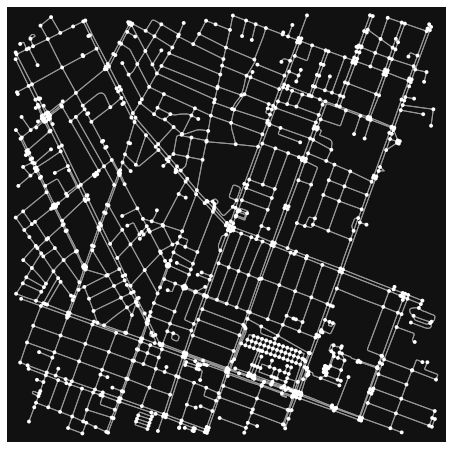

In [21]:
city_address = 'Natal, Rio Grande do Norte'
G = ox.graph_from_address(city_address, network_type='walk')
G = ox.project_graph(G)
cityGraph, axes = ox.plot_graph(G)

With this graph in hand, we extract dataframes for the nodes and edges. They are the input for the Pandana network, with which we can retrieve points of interest and calculate the distances.

In the edges dataframes, the id nodes are used as indexes. We will have to transform them in columns again, get the sources and the targets as nodes of the network instead of the dataframe returned by the function. We do that trying to decrease the number of nodes

In [22]:
nodes_, edges = ox.utils_graph.graph_to_gdfs(G)

# transform indexes into columns to get the nodes
edges.reset_index(inplace=True)

# check out the result
edges.head(2)

u           v  key      osmid  oneway lanes  \
0  300389748  2415142114    0  865381808   False     3   
1  300389748  6991058202    0  865381808   False     3   

                        name  highway  length  \
0  Avenida Hermes da Fonseca  primary   7.610   
1  Avenida Hermes da Fonseca  primary  19.081   

                                            geometry maxspeed service  \
0  LINESTRING (256284.363 -641722.743, 256287.149...      NaN     NaN   
1  LINESTRING (256284.363 -641722.743, 256277.108...      NaN     NaN   

  junction  ref access bridge width tunnel  
0      NaN  NaN    NaN    NaN   NaN    NaN  
1      NaN  NaN    NaN    NaN   NaN    NaN

In [23]:
nodes_.head()

y              x  street_count        lon       lat  \
osmid                                                                         
300389748  -641722.742756  256284.362613             3 -35.200877 -5.801386   
2415142114 -641715.696274  256287.149334             3 -35.200852 -5.801322   
6991058202 -641740.304771  256277.107548             3 -35.200943 -5.801545   
535292294  -641771.899546  256305.404447             3 -35.200689 -5.801831   
300392626  -642181.876505  255516.784047             4 -35.207821 -5.805509   

           highway                        geometry  
osmid                                               
300389748      NaN  POINT (256284.363 -641722.743)  
2415142114     NaN  POINT (256287.149 -641715.696)  
6991058202     NaN  POINT (256277.108 -641740.305)  
535292294      NaN  POINT (256305.404 -641771.900)  
300392626      NaN  POINT (255516.784 -642181.877)

In [24]:
sources = edges['u']
targets = edges['v']
nodes = nodes_.loc[pd.concat([sources, targets]).unique(), ['lon', 'lat', 'x', 'y']]
nodes.head(2)

lon       lat              x              y
osmid                                                        
300389748  -35.200877 -5.801386  256284.362613 -641722.742756
2415142114 -35.200852 -5.801322  256287.149334 -641715.696274

In [25]:
nodes_.head()

y              x  street_count        lon       lat  \
osmid                                                                         
300389748  -641722.742756  256284.362613             3 -35.200877 -5.801386   
2415142114 -641715.696274  256287.149334             3 -35.200852 -5.801322   
6991058202 -641740.304771  256277.107548             3 -35.200943 -5.801545   
535292294  -641771.899546  256305.404447             3 -35.200689 -5.801831   
300392626  -642181.876505  255516.784047             4 -35.207821 -5.805509   

           highway                        geometry  
osmid                                               
300389748      NaN  POINT (256284.363 -641722.743)  
2415142114     NaN  POINT (256287.149 -641715.696)  
6991058202     NaN  POINT (256277.108 -641740.305)  
535292294      NaN  POINT (256305.404 -641771.900)  
300392626      NaN  POINT (255516.784 -642181.877)

In [26]:
net=pdna.Network(nodes["lon"], nodes["lat"], edges["u"], edges["v"],
                 pd.DataFrame([edges['length']]).T, twoway=True)

net.precompute(5000)
net.edges_df.head(2)

from          to  length
0  300389748  2415142114   7.610
1  300389748  6991058202  19.081

#### Testing pandana `nearest_pois`

Let's make a quick test: search amenities for *one* neighborhood and see if we can calculate the distances.
First, we will convert the CRS for the coordinates oof the centroids, so we can further locate them.

In [27]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(neighborhood_df.x, neighborhood_df.y)]
geo_neighborhood_df = gpd.GeoDataFrame(neighborhood_df[['x', 'y']], crs=crs, geometry=geometry)

In [28]:
geo_neighborhood_df = geo_neighborhood_df.to_crs("epsg:2019")
geo_neighborhood_df.head(2)

x         y                         geometry
0 -35.199888 -5.762731  POINT (5777895.738 -890223.684)
1 -35.195083 -5.778860  POINT (5778390.091 -892772.226)

In [29]:
neighborhood_df['x_new'] = geo_neighborhood_df.geometry.x
neighborhood_df['y_new'] = geo_neighborhood_df.geometry.y

In [30]:
def get_points(s):
    # the amenity can be represented by point or polygon
    
    # if it is point, simply get x and y
    if type(s.geometry) is Point :
        y2 = s.geometry.y
        x2 = s.geometry.x
    elif type(s.geometry) is Polygon:
        y2 = s.geometry.centroid.y
        x2 = s.geometry.centroid.x
    else:
        y2, x2 = (None, None)
    return y2, x2

In [31]:
nordeste = neighborhood_df.query("name == 'Barro Vermelho'")
x = nordeste.x.tolist()[0]
y = nordeste.y.tolist()[0]
x1 = nordeste.x_new.tolist()[0]
y1 = nordeste.y_new.tolist()[0]
tags = {'amenity': ['school']}

point = (y, x)
    
# get amenities around the point
pois = ox.geometries.geometries_from_point(point, dist=5000, tags=tags)
a = pois.apply(lambda n : get_points(n), axis=1)
y_pois, x_pois = zip(*a.values.tolist())

x_series = pd.Series(x_pois)
y_series = pd.Series(y_pois)

In [32]:
# set_pois receives longitude (x) and then latitude (y)
net.set_pois("schools", 10000, 10, x_series, y_series)


/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinsta

In [33]:
net.nearest_pois(10000, "schools", num_pois=10)

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7            8            9            10  
osmid                                                                      
300389748   540.888000  540.888000   540.888000   677.112976   677.112976  
2415142114  533.278015  533.278015   533.278015   669.502991   669.502991  
6991058202  559.968994  559.968994   559.968994   696.193970   696.193970  
535292294   594.659973  594.659973   594.659973   730.885010   730.885010  
300392626   936.346008  958.739014  1004.346008  1050.656006  1050.656006  
...                ...         ...          ...          ...          ...  
7616375502  234.701996  234.701996   339.386993   339.386993   475.626007  
7616505043  223.677994  223.677994   370.502014   376.122009   376.122009  
7650782353  995.039001  995.039001   995.039001  1018.749023  1026.662964  
8418485280  409.375000  409.375000   510.225006   510.225006   510.225006  
8613242590  459.295013  731.049988   863.129028   863.129028   867.421997  

[1134 rows x 10 columns]

For each (x, y) that represents the centroid of a neighborhood, we will use `get_node_ids(x, y)` to get the node in the network closer to the point. That way, we can insert the smallest distance along with the other information about the neighborhood.

In [34]:
neighborhood_node_id = net.get_node_ids([x1], [y1])
neighborhood_node_id

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    503422409
Name: node_id, dtype: int64

In [39]:
nordeste

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id            name   income inhabitants       name_norm  zone  \
33  2408102036  Barro Vermelho  3208.73        6359  Barro Vermelho  East   

                                             geometry          x         y  \
33  POLYGON ((-35.21500 -5.79490, -35.21462 -5.795... -35.208673 -5.798518   

           x_new          y_new  
33  5.776002e+06 -895582.164844

In [35]:
net.nearest_pois(6000, "schools", num_pois=10).loc[neighborhood_node_id[0],:]

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1      49.337002
2     355.226990
3     355.226990
4     355.226990
5     355.226990
6     355.226990
7     453.846985
8     486.740997
9     937.885986
10    937.885986
Name: 503422409, dtype: float64

##### Calcutate the distance

Now, we can repeat all these steps for all neighborhoods and save them

In [36]:
amenities = ['hospital', 'restaurant', 'bank','school', 'police', 'pharmacy']

cols = ['nearest_' + amenity for amenity in amenities]
neighborhood_df = neighborhood_df.reindex(columns=neighborhood_df.columns.tolist() + cols)

In [37]:
for name in neighborhood_df.name.values:
    
    
    
    neighborhood = neighborhood_df.query(f"name == '{name}'")
    x = neighborhood.x.tolist()[0]
    y = neighborhood.y.tolist()[0]
    tags = {'amenity': amenities}

    point = (y, x)

    # get amenities around the point
    pois = ox.geometries.geometries_from_point(point, dist=6000, tags=tags)
    
     # calculate distances for each amenity
    for amenity in amenities:
        net=pdna.Network(nodes["lon"], nodes["lat"], edges["u"], edges["v"],
                 pd.DataFrame([edges['length']]).T, twoway=True)

        net.precompute(5000)
        
        neighborhood_node_id = net.get_node_ids([x], [y])
        
        a = pois.query(f'amenity == "{amenity}"').apply(lambda n : get_points(n), axis=1)
        y_pois, x_pois = zip(*a.values.tolist())

        x_series = pd.Series(x_pois)
        y_series = pd.Series(y_pois)
        
        # set_pois receives longitude (x) and then latitude (y)
        net.set_pois(amenity, 6000, 10, x_series, y_series)
        distance = net.nearest_pois(6000, amenity, num_pois=10)
        print(distance)
        print(distance.loc[neighborhood_node_id[0],1])
        neighborhood_df.loc[neighborhood.index, f'nearest_{amenity}'] = distance.loc[neighborhood_node_id[0],1]

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1230.432007  1230.432007   
8418485280  510.225006  767.809998   769.692017  1222.765015  1379.557007   
8613242590  602.325012  732.974976   945.869019   983.104004   986.802979   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  418.886993  418.886993   418.886993   418.886993   418.886993   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  480.326996   733.469971   746.914978  1408.291992   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  510.225006  678.130005  713.176025  767.731018   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1422.912964  1438.629028   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1230.432007  1278.636963  1295.076050  1295.076050   
8418485280  330.944000  1131.390991  1251.562012  1251.562012  1457.253052   
8613242590  983.104004   986.802979   986.802979  1076.261963  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  412.507996   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1216.683960  1230.432007   
8418485280  409.375000  510.225006   767.809998   769.692017   983.132996   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   418.886993   418.886993   418.886993   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  480.326996   733.469971   746.914978  1236.254028   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  510.225006   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1341.834961  1341.834961   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1230.432007  1278.636963   
8418485280  330.944000   890.903992  1131.390991  1236.254028  1236.254028   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1216.683960  1230.432007   
8418485280  409.375000  510.225006   767.809998   769.692017   983.132996   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   418.886993   418.886993   418.886993   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  480.326996   733.469971   746.914978  1236.254028   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  510.225006   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1341.834961  1422.912964   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1230.432007  1278.636963  1278.636963   
8418485280  330.944000   890.903992  1131.390991  1236.254028  1251.562012   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1216.683960  1230.432007   
8418485280  409.375000  510.225006   767.809998   769.692017   983.132996   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   418.886993   418.886993   418.886993   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  480.326996   733.469971   746.914978  1236.254028   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  510.225006   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1341.834961  1422.912964   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1230.432007  1278.636963  1278.636963   
8418485280  330.944000   890.903992  1131.390991  1236.254028  1251.562012   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1216.683960  1230.432007   
8418485280  409.375000  510.225006   767.809998   769.692017   983.132996   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   418.886993   418.886993   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  480.326996   733.469971   746.914978  1236.254028   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1341.834961  1341.834961   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1230.432007  1278.636963   
8418485280  330.944000   890.903992  1131.390991  1236.254028  1236.254028   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1216.683960  1230.432007   
8418485280  409.375000  510.225006   767.809998   769.692017   983.132996   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   418.886993   418.886993   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  480.326996   639.984009   733.469971   746.914978   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1341.834961  1341.834961   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1278.636963  1278.636963   
8418485280  330.944000   890.903992  1131.390991  1236.254028  1236.254028   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1216.683960  1230.432007   
8418485280  409.375000  510.225006   767.809998   769.692017   983.132996   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   418.886993   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  480.326996   639.984009   733.469971   746.914978   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1341.834961  1341.834961   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1278.636963  1278.636963   
8418485280  330.944000   890.903992  1131.390991  1236.254028  1236.254028   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1216.683960  1230.432007   
8418485280  409.375000  510.225006   767.809998   769.692017   983.132996   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  409.375000   480.326996   639.984009   733.469971   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1280.305054  1341.834961   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1230.432007  1278.636963   
8418485280  330.944000   409.375000   890.903992  1131.390991  1236.254028   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1216.683960  1230.432007   
8418485280  409.375000  510.225006   767.809998   769.692017   983.132996   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   418.886993   418.886993   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  480.326996   733.469971   746.914978   890.903992   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1341.834961  1341.834961   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1230.432007  1278.636963   
8418485280  330.944000   890.903992  1131.390991  1236.254028  1236.254028   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1131.646973  1216.683960   
8418485280  409.375000  409.375000   510.225006   767.809998   769.692017   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  409.375000   480.326996   639.984009   733.469971   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1173.074951  1280.305054   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1230.432007  1278.636963   
8418485280  330.944000   409.375000   639.984009   890.903992  1131.390991   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1216.683960  1230.432007   
8418485280  409.375000  510.225006   767.809998   769.692017   983.132996   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  480.326996   639.984009   733.469971   746.914978   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1280.305054  1341.834961   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1230.432007  1278.636963   
8418485280  330.944000   409.375000   890.903992  1131.390991  1236.254028   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1216.683960  1230.432007   
8418485280  409.375000  510.225006   767.809998   769.692017   983.132996   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  409.375000   480.326996   639.984009   733.469971   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1280.305054  1341.834961   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1230.432007  1278.636963   
8418485280  330.944000   409.375000   890.903992  1131.390991  1236.254028   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1216.683960  1230.432007   
8418485280  409.375000  510.225006   767.809998   769.692017   983.132996   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  540.888000   540.888000   540.888000   540.888000   
2415142114  501.083008  533.278015   533.278015   533.278015   533.278015   
6991058202  527.773987  559.968994   559.968994   559.968994   559.968994   
535292294   562.465027  583.773010   594.659973   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   418.886993   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  480.326996   639.984009   733.469971   746.914978   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  540.888000  540.888000  540.888000   
2415142114  441.756012  517.642029  533.278015  533.278015  533.278015   
6991058202  468.446991  544.333008  559.968994  559.968994  559.968994   
535292294   503.138000  579.023987  594.659973  594.659973  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1341.834961  1341.834961   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1230.432007  1278.636963   
8418485280  330.944000   890.903992  1236.254028  1236.254028  1251.562012   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1131.646973  1216.683960   
8418485280  409.375000  409.375000   510.225006   767.809998   769.692017   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  540.888000   540.888000   540.888000   540.888000   
2415142114  501.083008  533.278015   533.278015   533.278015   533.278015   
6991058202  527.773987  559.968994   559.968994   559.968994   559.968994   
535292294   562.465027  583.773010   594.659973   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  409.375000   480.326996   639.984009   733.469971   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  540.888000  540.888000  540.888000   
2415142114  441.756012  517.642029  533.278015  533.278015  533.278015   
6991058202  468.446991  544.333008  559.968994  559.968994  559.968994   
535292294   503.138000  579.023987  594.659973  594.659973  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1173.074951  1280.305054   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1230.432007  1278.636963   
8418485280  330.944000   409.375000   639.984009   890.903992  1236.254028   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1131.646973  1216.683960   
8418485280  409.375000  409.375000   510.225006   639.984009   767.809998   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  409.375000   480.326996   639.984009   733.469971   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1173.074951  1173.074951   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1278.636963  1278.636963   
8418485280  330.944000   409.375000   409.375000   639.984009   639.984009   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1131.646973  1216.683960   
8418485280  409.375000  409.375000   510.225006   767.809998   769.692017   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  409.375000   480.326996   639.984009   733.469971   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1173.074951  1280.305054   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1230.432007  1278.636963   
8418485280  330.944000   409.375000   639.984009   890.903992  1131.390991   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1131.646973  1216.683960   
8418485280  409.375000  409.375000   510.225006   639.984009   767.809998   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  409.375000   480.326996   639.984009   733.469971   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1173.074951  1173.074951   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1278.636963  1278.636963   
8418485280  330.944000   409.375000   409.375000   639.984009   639.984009   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1131.646973  1216.683960   
8418485280  409.375000  409.375000   510.225006   639.984009   767.809998   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  409.375000   480.326996   639.984009   733.469971   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982  1376.567017  1379.302002   
2415142114  533.278015   669.502991   722.533997  1371.692017  1384.177002   
6991058202  559.968994   696.193970   749.224976  1357.485962  1398.383057   
535292294   594.659973   730.885010   783.916016  1349.759033  1433.073975   
300392626   242.334000  1165.754028  1173.074951  1173.074951  1280.305054   
...                ...          ...          ...          ...          ...   
7616375502  618.257996   722.520996   949.619019  1115.119019  1866.207031   
7616505043  215.697006   376.122009   514.635010  1754.687988  1796.316040   
7650782353  550.687012  1131.646973  1131.646973  1278.636963  1278.636963   
8418485280  330.944000   409.375000   409.375000   639.984009   639.984009   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   722.520996   722.520996   949.619019   
7616505043  215.697006  215.697006   215.697006   376.122009   376.122009   
7650782353  241.664993  372.315002  1043.470947  1131.646973  1216.683960   
8418485280  409.375000  409.375000   510.225006   639.984009   767.809998   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   602.237000   
2415142114  501.083008  517.642029   533.278015   533.278015   594.627014   
6991058202  527.773987  544.333008   559.968994   559.968994   591.500000   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  544.570984  544.570984   618.257996   793.169006   816.706970   
7616505043  207.119003  215.697006   215.697006   223.677994   305.473999   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   730.143982  1396.760010  1504.733032  1720.328979  1760.667969   
2415142114  722.533997  1404.369995  1512.343018  1727.938965  1768.277954   
6991058202  749.224976  1377.678955  1485.651978  1701.248047  1741.587036   
535292294   783.916016  1369.952026  1477.925049  1693.520996  1733.859985   
300392626   473.403015   513.088989  1009.810974  1117.400024  1155.505005   
...                ...          ...          ...          ...          ...   
7616375502  618.257996  1534.619019  1552.910034  1656.953979  1739.734985   
7616505043  514.635010  1816.509033  1924.482056  2123.825928  2163.511963   
7650782353  417.864014   758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007   409.375000   409.375000   480.326996   639.984009   
8613242590  407.988007   542.067017   721.937012   731.049988   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  339.386993   
7616505043  215.697006  223.677994  223.677994  223.677994  370.502014   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   730.143982  1376.567017  1379.302002  1628.458008  1628.458008   
2415142114  722.533997  1371.692017  1384.177002  1636.067993  1636.067993   
6991058202  749.224976  1357.485962  1398.383057  1609.376953  1609.376953   
535292294   783.916016  1349.759033  1433.073975  1601.650024  1601.650024   
300392626   242.334000  1165.754028  1173.074951  1173.074951  1280.305054   
...                ...          ...          ...          ...          ...   
7616375502  618.257996  1115.119019  1866.207031  1866.207031  2220.737061   
7616505043  514.635010  1754.687988  1796.316040  2068.804932  2068.804932   
7650782353  550.687012  1131.646973  1131.646973  1278.636963  1278.636963   
8418485280  330.944000   409.375000   409.375000   639.984009   639.984009   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  814.674011   
2415142114  379.800995  517.642029  533.278015  533.278015  807.064026   
6991058202  406.492004  544.333008  559.968994  559.968994  833.755005   
535292294   441.183014  579.023987  594.659973  594.659973  868.445984   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  488.289001  558.039001  949.619019  949.619019   
7616505043  215.697006  215.697006  223.677994  765.369019  863.929993   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   618.257996   722.520996   
7616505043  215.697006  215.697006   215.697006   215.697006   376.122009   
7650782353  241.664993  372.315002  1043.470947  1131.646973  1216.683960   
8418485280  409.375000  409.375000   510.225006   639.984009   767.809998   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  409.375000   409.375000   480.326996   639.984009   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   730.143982  1376.567017  1379.302002  1628.458008  1774.223999   
2415142114  722.533997  1371.692017  1384.177002  1636.067993  1781.833984   
6991058202  749.224976  1357.485962  1398.383057  1609.376953  1755.142944   
535292294   783.916016  1349.759033  1433.073975  1601.650024  1747.416016   
300392626   242.334000  1165.754028  1173.074951  1173.074951  1280.305054   
...                ...          ...          ...          ...          ...   
7616375502  618.257996  1115.119019  1866.207031  1866.207031  2220.737061   
7616505043  514.635010  1754.687988  1796.316040  2068.804932  2193.972900   
7650782353  550.687012  1131.646973  1131.646973  1278.636963  1278.636963   
8418485280  330.944000   409.375000   409.375000   639.984009   639.984009   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  339.386993  339.386993  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   730.143982  730.143982   938.974976   938.974976   938.974976   
2415142114  722.533997  722.533997   931.364990   931.364990   931.364990   
6991058202  749.224976  749.224976   958.056030   958.056030   958.056030   
535292294   783.916016  783.916016   991.418030   992.747009   992.747009   
300392626   265.088013  688.442017   819.091980  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  514.635010  514.635010   863.929993   863.929993   863.929993   
7650782353  241.664993  372.315002  1043.470947  1131.646973  1216.683960   
8418485280  409.375000  409.375000   510.225006   639.984009   769.692017   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   602.237000  758.392029   758.392029   938.974976   938.974976   
2415142114  594.627014  750.781982   750.781982   931.364990   931.364990   
6991058202  591.500000  777.473022   777.473022   958.056030   958.056030   
535292294   583.773010  812.164001   812.164001   992.747009   992.747009   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  863.929993  863.929993   863.929993   863.929993   863.929993   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   730.143982  938.974976   938.974976   938.974976   938.974976   
2415142114  722.533997  931.364990   931.364990   931.364990   931.364990   
6991058202  749.224976  958.056030   958.056030   958.056030   958.056030   
535292294   783.916016  992.747009   992.747009   992.747009   992.747009   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  514.635010  863.929993   863.929993   863.929993   863.929993   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  409.375000   480.326996   639.984009   733.469971   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   730.143982  730.143982  730.143982  730.143982  730.143982   
2415142114  722.533997  722.533997  722.533997  722.533997  722.533997   
6991058202  749.224976  749.224976  749.224976  749.224976  749.224976   
535292294   783.916016  783.916016  783.916016  783.916016  783.916016   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  514.635010  514.635010  514.635010  514.635010  514.635010   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   938.974976  1376.567017  1379.302002  1774.223999  1774.223999   
2415142114  931.364990  1371.692017  1384.177002  1781.833984  1781.833984   
6991058202  958.056030  1357.485962  1398.383057  1755.142944  1755.142944   
535292294   992.747009  1349.759033  1433.073975  1747.416016  1747.416016   
300392626   242.334000  1079.017944  1165.754028  1173.074951  1173.074951   
...                ...          ...          ...          ...          ...   
7616375502  234.701996  1115.119019  1866.207031  1866.207031  2220.737061   
7616505043  863.929993  1754.687988  1796.316040  2193.972900  2193.972900   
7650782353  550.687012  1131.646973  1131.646973  1278.636963  1278.636963   
8418485280  330.944000   409.375000   409.375000   639.984009   639.984009   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  730.143982  730.143982  814.674011  938.974976   
2415142114  379.800995  722.533997  722.533997  807.064026  931.364990   
6991058202  406.492004  749.224976  749.224976  833.755005  958.056030   
535292294   441.183014  783.916016  783.916016  868.445984  992.747009   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  514.635010  514.635010  765.369019  863.929993  863.929993   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2248.658936  2300.335938  2402.980957  2419.111084  2749.940918   
2415142114  2241.049072  2292.726074  2395.371094  2411.500977  2757.551025   
6991058202  2267.739990  2319.416992  2422.062012  2438.191895  2730.860107   
535292294   2302.430908  2354.107910  2456.752930  2472.883057  2723.133057   
300392626   1438.629028  1490.306030  1506.441040  1506.441040  1592.951050   
...                 ...          ...          ...          ...          ...   
7616375502  1711.885010  1763.562012  1866.207031  1882.337036  2510.342041   
7616505043  2440.603027  2492.280029  2594.925049  2611.054932  3149.910889   
7650782353  1230.432007  1278.636963  1278.636963  1278.636963  1278.636963   
8418485280  1402.287964  1402.287964  1682.646973  1682.646973  1682.646973   
8613242590   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2340.664062  2402.980957  2419.111084  2419.111084  2749.940918   
2415142114  2333.053955  2395.371094  2411.500977  2411.500977  2757.551025   
6991058202  2359.745117  2422.062012  2438.191895  2438.191895  2730.860107   
535292294   2394.436035  2456.752930  2472.883057  2472.883057  2723.133057   
300392626   1506.441040  1506.441040  1506.441040  1506.441040  1506.441040   
...                 ...          ...          ...          ...          ...   
7616375502  1803.890015  1866.207031  1882.337036  1882.337036  2510.342041   
7616505043  2532.607910  2594.925049  2611.054932  2611.054932  3149.910889   
7650782353  1163.656006  1250.399048  1278.636963  1278.636963  1278.636963   
8418485280  1402.287964  1402.287964  1402.287964  1402.287964  1402.287964   
8613242590   863.129028   867.421997   945.869019   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2276.509033  2280.645020  2300.335938  2373.714111  2393.668945   
2415142114  2268.898926  2273.034912  2292.726074  2366.104004  2386.059082   
6991058202  2295.590088  2299.726074  2319.416992  2392.794922  2412.750000   
535292294   2330.281006  2334.416992  2354.107910  2427.486084  2447.440918   
300392626   1441.301025  1445.437012  1490.306030  1538.505981  1583.639038   
...                 ...          ...          ...          ...          ...   
7616375502  1739.734985  1743.870972  1763.562012  1836.939941  1856.895020   
7616505043  2468.452881  2472.589111  2492.280029  2565.657959  2585.613037   
7650782353  1105.843018  1114.285034  1180.078979  1230.432007  1278.636963   
8418485280  1682.646973  1682.646973  2012.990967  2022.104004  2036.328003   
8613242590   542.067017   721.937012   731.049988   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2280.645020  2340.664062  2340.664062  2402.980957  2402.980957   
2415142114  2273.034912  2333.053955  2333.053955  2395.371094  2395.371094   
6991058202  2299.726074  2359.745117  2359.745117  2422.062012  2422.062012   
535292294   2334.416992  2394.436035  2394.436035  2456.752930  2456.752930   
300392626   1445.437012  1472.500000  1472.500000  1472.500000  1496.706055   
...                 ...          ...          ...          ...          ...   
7616375502  1743.870972  1803.890015  1803.890015  1866.207031  1866.207031   
7616505043  2472.589111  2532.607910  2532.607910  2594.925049  2594.925049   
7650782353   995.039001   995.039001   995.039001  1058.000000  1114.285034   
8418485280  1402.287964  1402.287964  1402.287964  1402.287964  1402.287964   
8613242590   378.431000   459.295013   459.295013   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2402.980957  2402.980957  2749.940918  2749.940918  2961.143066   
2415142114  2395.371094  2395.371094  2757.551025  2757.551025  2953.532959   
6991058202  2422.062012  2422.062012  2730.860107  2730.860107  2975.054932   
535292294   2456.752930  2456.752930  2723.133057  2723.133057  2967.327881   
300392626   1506.441040  1506.441040  1592.951050  1592.951050  1756.098022   
...                 ...          ...          ...          ...          ...   
7616375502  1866.207031  1866.207031  2510.342041  2510.342041  2696.959961   
7616505043  2594.925049  2594.925049  3149.910889  3149.910889  3336.529053   
7650782353  1278.636963  1278.636963  1278.636963  1278.636963  1278.636963   
8418485280  1402.287964  1402.287964  1682.646973  1682.646973  1682.646973   
8613242590   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2248.658936  2280.645020  2300.335938  2300.335938  2340.664062   
2415142114  2241.049072  2273.034912  2292.726074  2292.726074  2333.053955   
6991058202  2267.739990  2299.726074  2319.416992  2319.416992  2359.745117   
535292294   2302.430908  2334.416992  2354.107910  2354.107910  2394.436035   
300392626   1438.629028  1445.437012  1490.306030  1490.306030  1506.441040   
...                 ...          ...          ...          ...          ...   
7616375502  1711.885010  1743.870972  1763.562012  1763.562012  1803.890015   
7616505043  2440.603027  2472.589111  2492.280029  2492.280029  2532.607910   
7650782353  1114.285034  1163.656006  1230.432007  1230.432007  1250.399048   
8418485280  1402.287964  1402.287964  1402.287964  1402.287964  1402.287964   
8613242590   731.049988   863.129028   867.421997   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1510.756958  1516.251953  1577.495972  1756.453003  1774.223999   
2415142114  1518.366943  1523.862061  1585.105957  1764.062988  1781.833984   
6991058202  1491.676025  1497.171021  1558.415039  1737.371948  1755.142944   
535292294   1483.948975  1489.443970  1550.687988  1729.645020  1747.416016   
300392626   1098.904053  1173.074951  1280.305054  1280.305054  1327.239990   
...                 ...          ...          ...          ...          ...   
7616375502  2140.924072  2228.058105  2335.288086  2335.288086  2352.135010   
7616505043  1951.104004  1956.598999  2017.843018  2193.972900  2193.972900   
7650782353  1131.646973  1216.683960  1278.636963  1278.636963  1278.636963   
8418485280   409.375000   409.375000   510.225006   639.984009   767.809998   
8613242590   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1453.311035  1453.311035  1474.578003  1474.578003  1478.480957   
2415142114  1460.921021  1460.921021  1482.187988  1482.187988  1486.090942   
6991058202  1434.229980  1434.229980  1455.496948  1455.496948  1459.400024   
535292294   1426.503052  1426.503052  1447.770020  1447.770020  1451.672974   
300392626    745.820007   745.820007   755.770996   767.086975   767.086975   
...                 ...          ...          ...          ...          ...   
7616375502  1800.802979  1800.802979  1810.754028  1822.069946  1822.069946   
7616505043  1871.380005  1871.380005  1892.646973  1892.646973  1913.900024   
7650782353  1036.259033  1036.259033  1045.338013  1057.526001  1057.526001   
8418485280   409.375000   409.375000   409.375000   409.375000   409.375000   
8613242590   863.129028   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1396.760010  1504.733032  1720.328979  1760.667969  1774.223999   
2415142114  1404.369995  1512.343018  1727.938965  1768.277954  1781.833984   
6991058202  1377.678955  1485.651978  1701.248047  1741.587036  1755.142944   
535292294   1369.952026  1477.925049  1693.520996  1733.859985  1747.416016   
300392626    473.403015   513.088989  1117.400024  1155.505005  1173.074951   
...                 ...          ...          ...          ...          ...   
7616375502  1534.619019  1552.910034  2172.383057  2210.488037  2228.058105   
7616505043  1816.509033  1924.482056  2123.825928  2163.511963  2193.972900   
7650782353   758.038025   770.388000  1131.646973  1131.646973  1131.646973   
8418485280   401.945007   409.375000   409.375000   480.326996   639.984009   
8613242590   926.661987   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1270.168945  1516.251953  1516.251953  1516.251953  1516.251953   
2415142114  1277.779053  1523.862061  1523.862061  1523.862061  1523.862061   
6991058202  1251.088013  1497.171021  1497.171021  1497.171021  1497.171021   
535292294   1243.360962  1489.443970  1489.443970  1489.443970  1489.443970   
300392626    842.570984   867.809021   936.346008  1050.656006  1050.656006   
...                 ...          ...          ...          ...          ...   
7616375502  1897.553955  1909.828979  1978.365967  2092.676025  2092.676025   
7616505043  1710.515991  1956.598999  1956.598999  1956.598999  1956.598999   
7650782353   739.491028   750.062988   811.192017   995.039001   995.039001   
8418485280   372.815002   409.375000   409.375000   409.375000   409.375000   
8613242590   362.528015   454.529999   459.295013   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1376.567017  1628.458008  1628.458008  1774.223999  1774.223999   
2415142114  1384.177002  1636.067993  1636.067993  1781.833984  1781.833984   
6991058202  1357.485962  1609.376953  1609.376953  1755.142944  1755.142944   
535292294   1349.759033  1601.650024  1601.650024  1747.416016  1747.416016   
300392626   1165.754028  1173.074951  1173.074951  1280.305054  1280.305054   
...                 ...          ...          ...          ...          ...   
7616375502  2220.737061  2228.058105  2228.058105  2335.288086  2335.288086   
7616505043  1796.316040  2068.804932  2068.804932  2193.972900  2193.972900   
7650782353  1131.646973  1131.646973  1278.636963  1278.636963  1278.636963   
8418485280   330.944000   409.375000   409.375000   639.984009   639.984009   
8613242590   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1516.251953  1516.251953  1516.251953  1536.180054  1617.755981   
2415142114  1523.862061  1523.862061  1523.862061  1543.790039  1625.365967   
6991058202  1497.171021  1497.171021  1497.171021  1517.098999  1598.675049   
535292294   1489.443970  1489.443970  1489.443970  1509.371948  1590.947998   
300392626    370.177002   419.635986   643.302002   842.570984   909.557007   
...                 ...          ...          ...          ...          ...   
7616375502  1409.998047  1480.852051  1704.517944  1897.553955  1964.540039   
7616505043  1955.928955  1956.598999  1956.598999  1956.598999  2020.599976   
7650782353   628.054016   704.270996   820.117981  1026.662964  1091.521973   
8418485280   171.330994   372.815002   409.375000   409.375000   409.375000   
8613242590   863.129028   917.838013   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1516.251953  1577.495972  1774.223999  1774.223999  1901.806030   
2415142114  1523.862061  1585.105957  1781.833984  1781.833984  1909.416016   
6991058202  1497.171021  1558.415039  1755.142944  1755.142944  1882.724976   
535292294   1489.443970  1550.687988  1747.416016  1747.416016  1874.998047   
300392626   1098.904053  1173.074951  1280.305054  1280.305054  1327.239990   
...                 ...          ...          ...          ...          ...   
7616375502  2140.924072  2228.058105  2335.288086  2335.288086  2352.135010   
7616505043  1956.598999  2017.843018  2193.972900  2193.972900  2342.153076   
7650782353  1131.646973  1216.683960  1278.636963  1278.636963  1278.636963   
8418485280   409.375000   409.375000   510.225006   639.984009   767.809998   
8613242590   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1516.251953  1516.251953  1516.251953  1774.223999  1774.223999   
2415142114  1523.862061  1523.862061  1523.862061  1781.833984  1781.833984   
6991058202  1497.171021  1497.171021  1497.171021  1755.142944  1755.142944   
535292294   1489.443970  1489.443970  1489.443970  1747.416016  1747.416016   
300392626   1050.656006  1050.656006  1050.656006  1173.074951  1173.074951   
...                 ...          ...          ...          ...          ...   
7616375502  2092.676025  2092.676025  2092.676025  2228.058105  2228.058105   
7616505043  1956.598999  1956.598999  1956.598999  2193.972900  2193.972900   
7650782353  1131.646973  1131.646973  1131.646973  1131.646973  1131.646973   
8418485280   409.375000   409.375000   409.375000   409.375000   409.375000   
8613242590   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1774.223999  1774.223999  1852.436035  1852.436035  1852.436035   
2415142114  1781.833984  1781.833984  1860.046021  1860.046021  1860.046021   
6991058202  1755.142944  1755.142944  1833.354980  1833.354980  1833.354980   
535292294   1747.416016  1747.416016  1825.628052  1825.628052  1825.628052   
300392626   1173.074951  1280.305054  1280.305054  1341.834961  1341.834961   
...                 ...          ...          ...          ...          ...   
7616375502  2228.058105  2335.288086  2335.288086  2352.135010  2352.135010   
7616505043  2193.972900  2193.972900  2292.782959  2292.782959  2292.782959   
7650782353  1131.646973  1131.646973  1131.646973  1131.646973  1131.646973   
8418485280   409.375000   409.375000   639.984009   890.903992   890.903992   
8613242590   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1516.251953  1516.251953  1516.251953  1516.251953  1667.761963   
2415142114  1523.862061  1523.862061  1523.862061  1523.862061  1675.371948   
6991058202  1497.171021  1497.171021  1497.171021  1497.171021  1648.681030   
535292294   1489.443970  1489.443970  1489.443970  1489.443970  1640.953979   
300392626   1050.656006  1050.656006  1126.702026  1173.074951  1173.074951   
...                 ...          ...          ...          ...          ...   
7616375502  2092.676025  2092.676025  2187.917969  2228.058105  2228.058105   
7616505043  1956.598999  1956.598999  1956.598999  1956.598999  2108.108887   
7650782353  1131.646973  1131.646973  1131.646973  1131.646973  1163.656006   
8418485280   409.375000   409.375000   409.375000   409.375000   409.375000   
8613242590   863.129028   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1774.223999  1774.223999  1852.436035  1852.436035  1852.436035   
2415142114  1781.833984  1781.833984  1860.046021  1860.046021  1860.046021   
6991058202  1755.142944  1755.142944  1833.354980  1833.354980  1833.354980   
535292294   1747.416016  1747.416016  1825.628052  1825.628052  1825.628052   
300392626   1173.074951  1173.074951  1280.305054  1280.305054  1341.834961   
...                 ...          ...          ...          ...          ...   
7616375502  2228.058105  2228.058105  2335.288086  2335.288086  2352.135010   
7616505043  2193.972900  2193.972900  2292.782959  2292.782959  2292.782959   
7650782353  1131.646973  1131.646973  1278.636963  1278.636963  1278.636963   
8418485280   409.375000   409.375000   639.984009   639.984009   890.903992   
8613242590   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1516.251953  1516.251953  1516.251953  1774.223999  1774.223999   
2415142114  1523.862061  1523.862061  1523.862061  1781.833984  1781.833984   
6991058202  1497.171021  1497.171021  1497.171021  1755.142944  1755.142944   
535292294   1489.443970  1489.443970  1489.443970  1747.416016  1747.416016   
300392626   1098.904053  1098.904053  1126.702026  1173.074951  1173.074951   
...                 ...          ...          ...          ...          ...   
7616375502  2140.924072  2140.924072  2187.917969  2228.058105  2228.058105   
7616505043  1956.598999  1956.598999  1956.598999  2193.972900  2193.972900   
7650782353  1131.646973  1131.646973  1131.646973  1216.683960  1216.683960   
8418485280   409.375000   409.375000   409.375000   409.375000   409.375000   
8613242590   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    207.632996   246.408005  1009.229980  1510.756958  1516.251953   
2415142114   215.242996   254.018005  1001.619995  1518.366943  1523.862061   
6991058202   188.552002   227.326996   999.145020  1491.676025  1497.171021   
535292294    180.824997   219.600006   991.418030  1483.948975  1489.443970   
300392626    265.088013   688.442017   819.091980  1013.385986  1052.161011   
...                 ...          ...          ...          ...          ...   
7616375502  1053.614990  1128.806030  1167.276978  1512.490967  1570.282959   
7616505043   647.979980   686.755005  1398.563965  1951.104004  1956.598999   
7650782353   241.664993   372.315002  1043.470947  1131.646973  1216.683960   
8418485280   409.375000   409.375000   510.225006   639.984009   767.809998   
8613242590   602.325012   732.974976   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1248.348999  1446.056030  1453.311035  1453.311035  1474.578003   
2415142114  1255.262939  1438.446045  1460.921021  1460.921021  1482.187988   
6991058202  1229.267944  1434.229980  1434.229980  1455.496948  1455.496948   
535292294   1221.541016  1426.503052  1426.503052  1447.770020  1447.770020   
300392626     11.445000   325.221008   745.820007   745.820007   755.770996   
...                 ...          ...          ...          ...          ...   
7616375502  1072.661011  1181.873047  1800.802979  1800.802979  1810.754028   
7616505043  1652.207031  1821.442017  1871.380005  1871.380005  1892.646973   
7650782353   478.351013   789.828003  1036.259033  1036.259033  1045.338013   
8418485280   409.375000   409.375000   409.375000   409.375000   409.375000   
8613242590   863.129028   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1396.760010  1504.733032  1720.328979  1760.667969  1774.223999   
2415142114  1404.369995  1512.343018  1727.938965  1768.277954  1781.833984   
6991058202  1377.678955  1485.651978  1701.248047  1741.587036  1755.142944   
535292294   1369.952026  1477.925049  1693.520996  1733.859985  1747.416016   
300392626    473.403015   513.088989  1009.810974  1117.400024  1155.505005   
...                 ...          ...          ...          ...          ...   
7616375502  1534.619019  1552.910034  1656.953979  2172.383057  2210.488037   
7616505043  1816.509033  1924.482056  2123.825928  2163.511963  2193.972900   
7650782353   417.864014   758.038025   770.388000  1131.646973  1131.646973   
8418485280   401.945007   409.375000   409.375000   480.326996   639.984009   
8613242590   407.988007   926.661987   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    890.309021  1003.010986  1231.332031  1270.168945  1516.251953   
2415142114   897.919006   995.401001  1223.722046  1277.779053  1523.862061   
6991058202   871.228027  1022.091980  1250.412964  1251.088013  1497.171021   
535292294    863.500977  1056.782959  1243.360962  1285.104004  1489.443970   
300392626    382.666992   390.303986   518.239990   842.570984   867.809021   
...                 ...          ...          ...          ...          ...   
7616375502   758.831970   967.148987  1431.368042  1897.553955  1909.828979   
7616505043  1308.378052  1378.396973  1606.718018  1710.515991  1956.598999   
7650782353   693.075012   739.491028   750.062988   811.192017   921.395996   
8418485280   372.815002   409.375000   409.375000   409.375000   409.375000   
8613242590   362.528015   378.431000   454.529999   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1376.567017  1379.302002  1628.458008  1628.458008  1774.223999   
2415142114  1371.692017  1384.177002  1636.067993  1636.067993  1781.833984   
6991058202  1357.485962  1398.383057  1609.376953  1609.376953  1755.142944   
535292294   1349.759033  1433.073975  1601.650024  1601.650024  1747.416016   
300392626    242.334000  1165.754028  1173.074951  1173.074951  1280.305054   
...                 ...          ...          ...          ...          ...   
7616375502  1115.119019  2220.737061  2228.058105  2228.058105  2335.288086   
7616505043  1754.687988  1796.316040  2068.804932  2068.804932  2193.972900   
7650782353   550.687012  1131.646973  1131.646973  1278.636963  1278.636963   
8418485280   330.944000   409.375000   409.375000   639.984009   639.984009   
8613242590   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1296.088989  1516.251953  1516.251953  1516.251953  1536.180054   
2415142114  1301.704956  1523.862061  1523.862061  1523.862061  1543.790039   
6991058202  1277.008057  1497.171021  1497.171021  1497.171021  1517.098999   
535292294   1269.281006  1489.443970  1489.443970  1489.443970  1509.371948   
300392626     36.387001   370.177002   419.635986   643.302002   842.570984   
...                 ...          ...          ...          ...          ...   
7616375502  1076.208008  1409.998047  1480.852051  1704.517944  1897.553955   
7616505043  1686.810059  1955.928955  1956.598999  1956.598999  1956.598999   
7650782353   628.054016   704.270996   765.510986   820.117981  1026.662964   
8418485280   171.330994   372.815002   409.375000   409.375000   409.375000   
8613242590   863.129028   917.838013   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1774.223999  1901.806030  1996.032959  2584.313965  2749.940918   
2415142114  1781.833984  1909.416016  2003.642944  2591.924072  2757.551025   
6991058202  1755.142944  1882.724976  1976.952026  2565.232910  2730.860107   
535292294   1747.416016  1874.998047  1969.224976  2557.506104  2723.133057   
300392626   1173.074951  1280.305054  1341.834961  1506.441040  1506.441040   
...                 ...          ...          ...          ...          ...   
7616375502  2228.058105  2335.288086  2352.135010  2510.342041  2510.342041   
7616505043  2193.972900  2342.153076  2414.102051  2991.704102  3149.910889   
7650782353  1131.646973  1289.854004  1289.854004  1345.227051  1461.459961   
8418485280   409.375000   639.984009  1091.671997  1236.254028  1402.287964   
8613242590  1194.501953  1194.501953  1196.241943  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1774.223999  1774.223999  1774.223999  1774.223999  1774.223999   
2415142114  1781.833984  1781.833984  1781.833984  1781.833984  1781.833984   
6991058202  1755.142944  1755.142944  1755.142944  1755.142944  1755.142944   
535292294   1747.416016  1747.416016  1747.416016  1747.416016  1747.416016   
300392626   1173.074951  1173.074951  1173.074951  1173.074951  1173.074951   
...                 ...          ...          ...          ...          ...   
7616375502  2228.058105  2228.058105  2228.058105  2228.058105  2228.058105   
7616505043  2193.972900  2193.972900  2193.972900  2193.972900  2193.972900   
7650782353  1131.646973  1131.646973  1131.646973  1131.646973  1131.646973   
8418485280   409.375000   409.375000   409.375000   409.375000   409.375000   
8613242590   983.104004   983.104004  1194.501953  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1774.223999  1774.223999  1852.436035  1852.436035  1852.436035   
2415142114  1781.833984  1781.833984  1860.046021  1860.046021  1860.046021   
6991058202  1755.142944  1755.142944  1833.354980  1833.354980  1833.354980   
535292294   1747.416016  1747.416016  1825.628052  1825.628052  1825.628052   
300392626   1173.074951  1280.305054  1280.305054  1341.834961  1341.834961   
...                 ...          ...          ...          ...          ...   
7616375502  2228.058105  2335.288086  2335.288086  2352.135010  2352.135010   
7616505043  2193.972900  2193.972900  2292.782959  2292.782959  2292.782959   
7650782353  1131.646973  1131.646973  1131.646973  1131.646973  1131.646973   
8418485280   409.375000   409.375000   639.984009   890.903992   890.903992   
8613242590  1196.241943  1196.241943  1196.241943  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1774.223999  1774.223999  1774.223999  1774.223999  1774.223999   
2415142114  1781.833984  1781.833984  1781.833984  1781.833984  1781.833984   
6991058202  1755.142944  1755.142944  1755.142944  1755.142944  1755.142944   
535292294   1747.416016  1747.416016  1747.416016  1747.416016  1747.416016   
300392626   1173.074951  1173.074951  1173.074951  1173.074951  1280.305054   
...                 ...          ...          ...          ...          ...   
7616375502  2228.058105  2228.058105  2228.058105  2228.058105  2335.288086   
7616505043  2193.972900  2193.972900  2193.972900  2193.972900  2193.972900   
7650782353  1131.646973  1131.646973  1131.646973  1278.636963  1278.636963   
8418485280   409.375000   409.375000   409.375000   409.375000   409.375000   
8613242590   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1774.223999  1774.223999  1852.436035  1852.436035  1901.806030   
2415142114  1781.833984  1781.833984  1860.046021  1860.046021  1909.416016   
6991058202  1755.142944  1755.142944  1833.354980  1833.354980  1882.724976   
535292294   1747.416016  1747.416016  1825.628052  1825.628052  1874.998047   
300392626   1173.074951  1173.074951  1280.305054  1280.305054  1341.834961   
...                 ...          ...          ...          ...          ...   
7616375502  2228.058105  2228.058105  2335.288086  2335.288086  2352.135010   
7616505043  2193.972900  2193.972900  2292.782959  2292.782959  2342.153076   
7650782353  1131.646973  1278.636963  1289.854004  1289.854004  1345.227051   
8418485280   409.375000   409.375000   639.984009   639.984009   890.903992   
8613242590   983.104004  1194.501953  1194.501953  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1774.223999  1774.223999  1774.223999  1774.223999  1852.436035   
2415142114  1781.833984  1781.833984  1781.833984  1781.833984  1860.046021   
6991058202  1755.142944  1755.142944  1755.142944  1755.142944  1833.354980   
535292294   1747.416016  1747.416016  1747.416016  1747.416016  1825.628052   
300392626   1173.074951  1173.074951  1173.074951  1173.074951  1173.074951   
...                 ...          ...          ...          ...          ...   
7616375502  2228.058105  2228.058105  2228.058105  2228.058105  2228.058105   
7616505043  2193.972900  2193.972900  2193.972900  2193.972900  2292.782959   
7650782353  1131.646973  1131.646973  1289.854004  1289.854004  1289.854004   
8418485280   409.375000   409.375000   409.375000   409.375000   639.984009   
8613242590  1194.501953  1194.501953  1194.501953  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1832.011963  1834.465942  2248.658936  2300.335938  2300.335938   
2415142114  1824.401978  1826.855957  2241.049072  2292.726074  2292.726074   
6991058202  1851.093018  1853.546997  2267.739990  2317.200928  2319.416992   
535292294   1885.784058  1888.238037  2302.430908  2309.474121  2354.107910   
300392626    688.442017   819.091980  1098.904053  1438.629028  1490.306030   
...                 ...          ...          ...          ...          ...   
7616375502  1512.490967  1570.282959  1711.885010  1763.562012  1763.562012   
7616505043  2207.397949  2209.852051  2440.603027  2492.280029  2492.280029   
7650782353   241.664993   372.315002  1216.683960  1230.432007  1230.432007   
8418485280   983.132996  1420.776001  1551.426025  1682.646973  2236.923096   
8613242590   602.325012   732.974976   945.869019   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1143.150024  1446.056030  1996.032959  2248.658936  2248.658936   
2415142114  1135.540039  1438.446045  2003.642944  2241.049072  2241.049072   
6991058202  1162.230957  1465.136963  1976.952026  2267.739990  2267.739990   
535292294   1196.921997  1499.828003  1969.224976  2261.226074  2302.430908   
300392626    325.221008  1050.656006  1095.292969  1173.074951  1341.834961   
...                 ...          ...          ...          ...          ...   
7616375502   339.386993  1181.873047  1711.885010  1711.885010  1711.885010   
7616505043  1068.104980  1821.442017  2414.102051  2440.603027  2440.603027   
7650782353   478.351013  1131.646973  1131.646973  1131.646973  1131.646973   
8418485280   639.984009   934.885010  1236.254028  1236.254028  1236.254028   
8613242590   863.129028   867.421997   945.869019   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1720.328979  1760.667969  1976.474976  2276.509033  2280.645020   
2415142114  1727.938965  1768.277954  1968.864990  2268.898926  2273.034912   
6991058202  1701.248047  1741.587036  1995.556030  2295.590088  2299.726074   
535292294   1693.520996  1733.859985  2030.246948  2330.281006  2334.416992   
300392626    473.403015   513.088989  1009.810974  1341.834961  1441.301025   
...                 ...          ...          ...          ...          ...   
7616375502  1534.619019  1552.910034  1656.953979  1739.734985  1743.870972   
7616505043  2123.825928  2163.511963  2351.861084  2468.452881  2472.589111   
7650782353   417.864014   758.038025   770.388000  1105.843018  1114.285034   
8418485280   733.469971   746.914978  1236.254028  1408.291992  2012.990967   
8613242590   407.988007   542.067017   721.937012   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1003.010986  1143.150024  1231.332031  1657.281006  1657.281006   
2415142114   995.401001  1135.540039  1223.722046  1649.671021  1649.671021   
6991058202  1022.091980  1162.230957  1250.412964  1670.954956  1676.362061   
535292294   1056.782959  1196.921997  1285.104004  1663.228027  1711.052979   
300392626    390.303986   518.239990   842.570984   867.809021   936.346008   
...                 ...          ...          ...          ...          ...   
7616375502   339.386993   758.831970   967.148987  1053.558960  1053.558960   
7616505043  1068.104980  1378.396973  1606.718018  1782.276978  1782.276978   
7650782353   693.075012   739.491028   750.062988   811.192017   921.395996   
8418485280   372.815002   713.176025   767.731018   836.268005   934.885010   
8613242590   362.528015   378.431000   454.529999   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1379.302002  2248.658936  2248.658936  2248.658936  2248.658936   
2415142114  1371.692017  2241.049072  2241.049072  2241.049072  2241.049072   
6991058202  1398.383057  2267.739990  2267.739990  2267.739990  2267.739990   
535292294   1433.073975  2302.430908  2302.430908  2302.430908  2302.430908   
300392626    242.334000  1341.834961  1438.629028  1438.629028  1438.629028   
...                 ...          ...          ...          ...          ...   
7616375502  1115.119019  1711.885010  1711.885010  1711.885010  1711.885010   
7616505043  1754.687988  2440.603027  2440.603027  2440.603027  2440.603027   
7650782353   550.687012  1131.646973  1230.432007  1278.636963  1278.636963   
8418485280  1236.254028  1457.253052  1682.646973  1682.646973  1682.646973   
8613242590   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1296.088989  1617.755981  1666.562012  1690.036011  1816.699951   
2415142114  1301.704956  1625.365967  1674.171997  1697.645996  1809.089966   
6991058202  1277.008057  1598.675049  1647.480957  1670.954956  1835.781006   
535292294   1269.281006  1590.947998  1639.754028  1663.228027  1863.420044   
300392626     36.387001   370.177002   419.635986   643.302002   842.570984   
...                 ...          ...          ...          ...          ...   
7616375502  1076.208008  1279.926025  1409.998047  1480.852051  1704.517944   
7616505043  1686.810059  2008.644043  2020.599976  2070.059082  2104.121094   
7650782353   628.054016   704.270996   765.510986   820.117981   979.312012   
8418485280   372.815002   578.880981   713.176025   800.682007   876.382019   
8613242590   731.049988   863.129028   867.421997   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2300.335938  2300.335938  2393.668945  2393.668945  2393.668945   
2415142114  2292.726074  2292.726074  2386.059082  2386.059082  2386.059082   
6991058202  2319.416992  2319.416992  2412.750000  2412.750000  2412.750000   
535292294   2354.107910  2354.107910  2447.440918  2447.440918  2447.440918   
300392626   1490.306030  1490.306030  1583.639038  1583.639038  1583.639038   
...                 ...          ...          ...          ...          ...   
7616375502  1763.562012  1763.562012  1856.895020  1856.895020  1856.895020   
7616505043  2492.280029  2492.280029  2585.613037  2585.613037  2585.613037   
7650782353  1230.432007  1230.432007  1323.765015  1323.765015  1323.765015   
8418485280  2236.923096  2262.979980  2262.979980  2262.979980  2361.355957   
8613242590   945.869019   986.802979   986.802979   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2248.658936  2248.658936  2248.658936  2248.658936  2248.658936   
2415142114  2241.049072  2241.049072  2241.049072  2241.049072  2241.049072   
6991058202  2267.739990  2267.739990  2267.739990  2267.739990  2267.739990   
535292294   2302.430908  2302.430908  2302.430908  2302.430908  2302.430908   
300392626   1438.629028  1438.629028  1438.629028  1438.629028  1438.629028   
...                 ...          ...          ...          ...          ...   
7616375502  1711.885010  1711.885010  1711.885010  1711.885010  1711.885010   
7616505043  2440.603027  2440.603027  2440.603027  2440.603027  2440.603027   
7650782353  1230.432007  1230.432007  1230.432007  1230.432007  1295.076050   
8418485280  2236.923096  2236.923096  2262.979980  2361.355957  2361.355957   
8613242590   945.869019   945.869019   986.802979  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2393.668945  2393.668945  2393.668945  2393.668945  2393.668945   
2415142114  2386.059082  2386.059082  2386.059082  2386.059082  2386.059082   
6991058202  2412.750000  2412.750000  2412.750000  2412.750000  2412.750000   
535292294   2447.440918  2447.440918  2447.440918  2447.440918  2447.440918   
300392626   1583.639038  1583.639038  1583.639038  1583.639038  1583.639038   
...                 ...          ...          ...          ...          ...   
7616375502  1856.895020  1856.895020  1856.895020  1856.895020  1856.895020   
7616505043  2585.613037  2585.613037  2585.613037  2585.613037  2585.613037   
7650782353  1323.765015  1323.765015  1323.765015  1323.765015  1323.765015   
8418485280  2262.979980  2361.355957  2361.355957  2361.355957  2361.355957   
8613242590   986.802979  1085.178955  1085.178955  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2248.658936  2248.658936  2248.658936  2248.658936  2248.658936   
2415142114  2241.049072  2241.049072  2241.049072  2241.049072  2241.049072   
6991058202  2267.739990  2267.739990  2267.739990  2267.739990  2267.739990   
535292294   2302.430908  2302.430908  2302.430908  2302.430908  2302.430908   
300392626   1438.629028  1438.629028  1438.629028  1438.629028  1438.629028   
...                 ...          ...          ...          ...          ...   
7616375502  1711.885010  1711.885010  1711.885010  1711.885010  1711.885010   
7616505043  2440.603027  2440.603027  2440.603027  2440.603027  2440.603027   
7650782353  1230.432007  1230.432007  1230.432007  1230.432007  1230.432007   
8418485280  2158.476074  2262.979980  2262.979980  2262.979980  2262.979980   
8613242590   867.421997   986.802979   986.802979   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2248.658936  2248.658936  2248.658936  2248.658936  2248.658936   
2415142114  2241.049072  2241.049072  2241.049072  2241.049072  2241.049072   
6991058202  2267.739990  2267.739990  2267.739990  2267.739990  2267.739990   
535292294   2302.430908  2302.430908  2302.430908  2302.430908  2302.430908   
300392626   1438.629028  1438.629028  1438.629028  1438.629028  1438.629028   
...                 ...          ...          ...          ...          ...   
7616375502  1711.885010  1711.885010  1711.885010  1711.885010  1711.885010   
7616505043  2440.603027  2440.603027  2440.603027  2440.603027  2440.603027   
7650782353  1230.432007  1295.076050  1295.076050  1295.076050  1295.076050   
8418485280  2262.979980  2262.979980  2262.979980  2361.355957  2361.355957   
8613242590   986.802979   986.802979   986.802979  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2248.658936  2248.658936  2300.335938  2393.668945  2393.668945   
2415142114  2241.049072  2241.049072  2292.726074  2386.059082  2386.059082   
6991058202  2267.739990  2267.739990  2319.416992  2412.750000  2412.750000   
535292294   2302.430908  2302.430908  2354.107910  2447.440918  2447.440918   
300392626   1438.629028  1438.629028  1490.306030  1583.639038  1583.639038   
...                 ...          ...          ...          ...          ...   
7616375502  1711.885010  1711.885010  1763.562012  1856.895020  1856.895020   
7616505043  2440.603027  2440.603027  2492.280029  2585.613037  2585.613037   
7650782353  1230.432007  1295.076050  1295.076050  1323.765015  1323.765015   
8418485280  2236.923096  2262.979980  2262.979980  2361.355957  2361.355957   
8613242590   945.869019   986.802979   986.802979  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    207.632996   246.408005   540.888000   540.888000   540.888000   
2415142114   215.242996   254.018005   533.278015   533.278015   533.278015   
6991058202   188.552002   227.326996   559.968994   559.968994   559.968994   
535292294    180.824997   219.600006   594.659973   594.659973   594.659973   
300392626    265.088013   688.442017   819.091980  1013.385986  1052.161011   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   234.701996   234.701996   234.701996   234.701996   
7616505043   215.697006   215.697006   215.697006   215.697006   215.697006   
7650782353   241.664993   372.315002  1043.470947  1230.432007  1230.432007   
8418485280  1222.765015  1420.776001  1461.103027  1499.878052  1551.426025   
8613242590   602.325012   732.974976   945.869019   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    508.692993   540.888000   540.888000   540.888000   540.888000   
2415142114   501.083008   533.278015   533.278015   533.278015   533.278015   
6991058202   527.773987   559.968994   559.968994   559.968994   559.968994   
535292294    562.465027   583.773010   594.659973   594.659973   594.659973   
300392626     11.445000   325.221008   516.645020   516.645020   671.343018   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   234.701996   234.701996   234.701996   234.701996   
7616505043   207.119003   215.697006   215.697006   215.697006   215.697006   
7650782353   478.351013   789.828003  1166.015015  1166.015015  1230.432007   
8418485280  1203.941040  1464.483032  1516.947021  1728.760986  1728.760986   
8613242590   867.421997   945.869019   945.869019   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    540.888000   677.112976   677.112976   730.143982   730.143982   
2415142114   533.278015   669.502991   669.502991   722.533997   722.533997   
6991058202   559.968994   696.193970   696.193970   749.224976   749.224976   
535292294    594.659973   730.885010   730.885010   783.916016   783.916016   
300392626   1009.810974  1079.017944  1079.017944  1079.017944  1079.017944   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   234.701996   234.701996   234.701996   234.701996   
7616505043   215.697006   376.122009   376.122009   514.635010   514.635010   
7650782353   417.864014  1105.843018  1114.285034  1180.078979  1230.432007   
8418485280  1408.291992  2012.990967  2022.104004  2036.328003  2230.750977   
8613242590   407.988007   542.067017   721.937012   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    449.365997   540.888000   540.888000   540.888000   540.888000   
2415142114   441.756012   533.278015   533.278015   533.278015   533.278015   
6991058202   468.446991   559.968994   559.968994   559.968994   559.968994   
535292294    503.138000   594.659973   594.659973   594.659973   594.659973   
300392626    382.666992   390.303986   518.239990   958.739014  1004.346008   
...                 ...          ...          ...          ...          ...   
7616375502   132.904007   180.531998   234.701996   234.701996   234.701996   
7616505043   215.697006   215.697006   215.697006   215.697006   370.502014   
7650782353   693.075012   739.491028   921.395996   995.039001   995.039001   
8418485280  1138.889038  1254.527954  1430.977051  1430.977051  1605.223022   
8613242590   362.528015   378.431000   459.295013   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    540.888000   677.112976   730.143982   938.974976  1379.302002   
2415142114   533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202   559.968994   696.193970   749.224976   958.056030  1398.383057   
535292294    594.659973   730.885010   783.916016   992.747009  1433.073975   
300392626    242.334000  1079.017944  1422.912964  1438.629028  1438.629028   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043   215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353   550.687012  1230.432007  1295.076050  1295.076050  1295.076050   
8418485280  1457.253052  2230.750977  2250.188965  2262.979980  2262.979980   
8613242590   986.802979   986.802979  1076.261963  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   387.411011   525.252014   540.888000   540.888000   540.888000   
2415142114  379.800995   517.642029   533.278015   533.278015   533.278015   
6991058202  406.492004   544.333008   559.968994   559.968994   559.968994   
535292294   441.183014   579.023987   594.659973   594.659973   594.659973   
300392626    36.387001   370.177002   572.927002   894.447021   990.174011   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   234.701996   234.701996   234.701996   339.386993   
7616505043  215.697006   215.697006   215.697006   215.697006   215.697006   
7650782353  628.054016   765.510986   979.312012  1114.285034  1191.938965   
8418485280  876.382019  1207.651978  1712.329956  1785.042969  2022.104004   
8613242590  731.049988   867.421997   945.869019   986.802979   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1216.683960  1230.432007   
8418485280  409.375000  510.225006   767.809998   769.692017   983.132996   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   418.886993   418.886993   418.886993   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  480.326996   733.469971   746.914978  1236.254028   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  510.225006   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1341.834961  1422.912964   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1230.432007  1278.636963  1278.636963   
8418485280  330.944000   890.903992  1131.390991  1236.254028  1251.562012   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2300.335938  2300.335938  2393.668945  2393.668945  2393.668945   
2415142114  2292.726074  2292.726074  2386.059082  2386.059082  2386.059082   
6991058202  2319.416992  2319.416992  2412.750000  2412.750000  2412.750000   
535292294   2354.107910  2354.107910  2447.440918  2447.440918  2447.440918   
300392626   1490.306030  1490.306030  1583.639038  1583.639038  1583.639038   
...                 ...          ...          ...          ...          ...   
7616375502  1763.562012  1763.562012  1856.895020  1856.895020  1856.895020   
7616505043  2492.280029  2492.280029  2585.613037  2585.613037  2585.613037   
7650782353  1230.432007  1230.432007  1323.765015  1323.765015  1323.765015   
8418485280  2262.979980  2361.355957  2361.355957  2361.355957  2361.355957   
8613242590   986.802979  1085.178955  1085.178955  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2248.658936  2248.658936  2248.658936  2248.658936  2248.658936   
2415142114  2241.049072  2241.049072  2241.049072  2241.049072  2241.049072   
6991058202  2267.739990  2267.739990  2267.739990  2267.739990  2267.739990   
535292294   2302.430908  2302.430908  2302.430908  2302.430908  2302.430908   
300392626   1438.629028  1438.629028  1438.629028  1438.629028  1438.629028   
...                 ...          ...          ...          ...          ...   
7616375502  1711.885010  1711.885010  1711.885010  1711.885010  1711.885010   
7616505043  2440.603027  2440.603027  2440.603027  2440.603027  2440.603027   
7650782353  1230.432007  1230.432007  1230.432007  1230.432007  1295.076050   
8418485280  2361.355957  2361.355957  2361.355957  2361.355957  2361.355957   
8613242590  1085.178955  1085.178955  1085.178955  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2393.668945  2393.668945  2393.668945  2393.668945  2393.668945   
2415142114  2386.059082  2386.059082  2386.059082  2386.059082  2386.059082   
6991058202  2412.750000  2412.750000  2412.750000  2412.750000  2412.750000   
535292294   2447.440918  2447.440918  2447.440918  2447.440918  2447.440918   
300392626   1583.639038  1583.639038  1583.639038  1583.639038  1583.639038   
...                 ...          ...          ...          ...          ...   
7616375502  1856.895020  1856.895020  1856.895020  1856.895020  1856.895020   
7616505043  2585.613037  2585.613037  2585.613037  2585.613037  2585.613037   
7650782353  1323.765015  1323.765015  1323.765015  1323.765015  1323.765015   
8418485280  2262.979980  2361.355957  2361.355957  2361.355957  2361.355957   
8613242590   986.802979  1085.178955  1085.178955  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    938.974976  1143.150024  2248.658936  2248.658936  2248.658936   
2415142114   931.364990  1135.540039  2241.049072  2241.049072  2241.049072   
6991058202   958.056030  1162.230957  2267.739990  2267.739990  2267.739990   
535292294    992.747009  1196.921997  2302.430908  2302.430908  2302.430908   
300392626   1079.017944  1095.292969  1438.629028  1438.629028  1438.629028   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   339.386993  1711.885010  1711.885010  1711.885010   
7616505043   863.929993  1068.104980  2440.603027  2440.603027  2440.603027   
7650782353  1230.432007  1230.432007  1230.432007  1230.432007  1230.432007   
8418485280  2262.979980  2262.979980  2262.979980  2262.979980  2262.979980   
8613242590   986.802979   986.802979   986.802979   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2248.658936  2248.658936  2248.658936  2248.658936  2248.658936   
2415142114  2241.049072  2241.049072  2241.049072  2241.049072  2241.049072   
6991058202  2267.739990  2267.739990  2267.739990  2267.739990  2267.739990   
535292294   2302.430908  2302.430908  2302.430908  2302.430908  2302.430908   
300392626   1438.629028  1438.629028  1438.629028  1438.629028  1438.629028   
...                 ...          ...          ...          ...          ...   
7616375502  1711.885010  1711.885010  1711.885010  1711.885010  1711.885010   
7616505043  2440.603027  2440.603027  2440.603027  2440.603027  2440.603027   
7650782353  1230.432007  1295.076050  1295.076050  1295.076050  1295.076050   
8418485280  2361.355957  2361.355957  2405.308105  2469.951904  2469.951904   
8613242590  1085.178955  1085.178955  1186.300049  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   2248.658936  2248.658936  2300.335938  2393.668945  2393.668945   
2415142114  2241.049072  2241.049072  2292.726074  2386.059082  2386.059082   
6991058202  2267.739990  2267.739990  2319.416992  2412.750000  2412.750000   
535292294   2302.430908  2302.430908  2354.107910  2447.440918  2447.440918   
300392626   1438.629028  1438.629028  1490.306030  1583.639038  1583.639038   
...                 ...          ...          ...          ...          ...   
7616375502  1711.885010  1711.885010  1763.562012  1856.895020  1856.895020   
7616505043  2440.603027  2440.603027  2492.280029  2585.613037  2585.613037   
7650782353  1230.432007  1295.076050  1295.076050  1323.765015  1323.765015   
8418485280  2262.979980  2262.979980  2361.355957  2361.355957  2361.355957   
8613242590   986.802979   986.802979  1085.178955  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    540.888000   540.888000   540.888000   540.888000   540.888000   
2415142114   533.278015   533.278015   533.278015   533.278015   533.278015   
6991058202   559.968994   559.968994   559.968994   559.968994   559.968994   
535292294    594.659973   594.659973   594.659973   594.659973   594.659973   
300392626   1079.017944  1079.017944  1079.017944  1079.017944  1422.912964   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   234.701996   234.701996   234.701996   618.257996   
7616505043   215.697006   215.697006   215.697006   215.697006   215.697006   
7650782353  1230.432007  1323.765015  1323.765015  1323.765015  1323.765015   
8418485280  2230.750977  2230.750977  2230.750977  2230.750977  2230.750977   
8613242590   986.802979  1085.178955  1085.178955  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    540.888000   540.888000   540.888000   540.888000   540.888000   
2415142114   533.278015   533.278015   533.278015   533.278015   533.278015   
6991058202   559.968994   559.968994   559.968994   559.968994   559.968994   
535292294    594.659973   594.659973   594.659973   594.659973   594.659973   
300392626   1079.017944  1079.017944  1079.017944  1079.017944  1079.017944   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   234.701996   234.701996   234.701996   234.701996   
7616505043   215.697006   215.697006   215.697006   215.697006   215.697006   
7650782353  1230.432007  1295.076050  1295.076050  1295.076050  1295.076050   
8418485280  2230.750977  2230.750977  2230.750977  2230.750977  2230.750977   
8613242590  1085.178955  1085.178955  1085.178955  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    540.888000   540.888000   677.112976   677.112976   730.143982   
2415142114   533.278015   533.278015   669.502991   669.502991   722.533997   
6991058202   559.968994   559.968994   696.193970   696.193970   749.224976   
535292294    594.659973   594.659973   730.885010   730.885010   783.916016   
300392626   1079.017944  1079.017944  1079.017944  1079.017944  1079.017944   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   234.701996   234.701996   234.701996   234.701996   
7616505043   215.697006   215.697006   376.122009   376.122009   514.635010   
7650782353  1323.765015  1323.765015  1323.765015  1323.765015  1323.765015   
8418485280  2230.750977  2230.750977  2250.188965  2262.979980  2288.170898   
8613242590   986.802979  1085.178955  1085.178955  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    540.888000   540.888000   540.888000   677.112976   677.112976   
2415142114   533.278015   533.278015   533.278015   669.502991   669.502991   
6991058202   559.968994   559.968994   559.968994   696.193970   696.193970   
535292294    594.659973   594.659973   594.659973   730.885010   730.885010   
300392626   1079.017944  1079.017944  1079.017944  1079.017944  1079.017944   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   234.701996   234.701996   234.701996   234.701996   
7616505043   215.697006   215.697006   215.697006   376.122009   376.122009   
7650782353  1230.432007  1230.432007  1230.432007  1230.432007  1295.076050   
8418485280  2230.750977  2230.750977  2230.750977  2250.188965  2250.188965   
8613242590   986.802979   986.802979   986.802979   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    540.888000   677.112976   938.974976  2248.658936  2248.658936   
2415142114   533.278015   669.502991   931.364990  2241.049072  2241.049072   
6991058202   559.968994   696.193970   958.056030  2267.739990  2267.739990   
535292294    594.659973   730.885010   992.747009  2302.430908  2302.430908   
300392626   1079.017944  1438.629028  1438.629028  1438.629028  1438.629028   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   722.520996   949.619019  1711.885010  1711.885010   
7616505043   215.697006   376.122009   863.929993  2440.603027  2440.603027   
7650782353  1230.432007  1295.076050  1295.076050  1295.076050  1295.076050   
8418485280  2230.750977  2288.170898  2354.092041  2361.355957  2361.355957   
8613242590  1085.178955  1085.178955  1186.300049  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    540.888000   540.888000   540.888000   540.888000   540.888000   
2415142114   533.278015   533.278015   533.278015   533.278015   533.278015   
6991058202   559.968994   559.968994   559.968994   559.968994   559.968994   
535292294    594.659973   594.659973   594.659973   594.659973   594.659973   
300392626   1079.017944  1079.017944  1079.017944  1095.292969  1095.292969   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   234.701996   234.701996   339.386993   339.386993   
7616505043   215.697006   215.697006   215.697006   215.697006   215.697006   
7650782353  1295.076050  1295.076050  1323.765015  1323.765015  1323.765015   
8418485280  2230.750977  2230.750977  2230.750977  2230.750977  2230.750977   
8613242590   986.802979   986.802979  1085.178955  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    207.632996   246.408005   540.888000   540.888000   540.888000   
2415142114   215.242996   254.018005   533.278015   533.278015   533.278015   
6991058202   188.552002   227.326996   559.968994   559.968994   559.968994   
535292294    180.824997   219.600006   594.659973   594.659973   594.659973   
300392626    265.088013   688.442017   819.091980  1013.385986  1052.161011   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   234.701996   234.701996   234.701996   234.701996   
7616505043   215.697006   215.697006   215.697006   215.697006   215.697006   
7650782353   241.664993   372.315002  1043.470947  1230.432007  1230.432007   
8418485280  1222.765015  1420.776001  1461.103027  1499.878052  1551.426025   
8613242590   602.325012   732.974976   945.869019   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    508.692993   525.252014   540.888000   540.888000   540.888000   
2415142114   501.083008   517.642029   533.278015   533.278015   533.278015   
6991058202   527.773987   544.333008   559.968994   559.968994   559.968994   
535292294    562.465027   579.023987   583.773010   594.659973   594.659973   
300392626     11.445000   325.221008   516.645020   516.645020   671.343018   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   234.701996   234.701996   234.701996   234.701996   
7616505043   207.119003   215.697006   215.697006   215.697006   215.697006   
7650782353   478.351013   789.828003  1166.015015  1166.015015  1230.432007   
8418485280  1203.941040  1464.483032  1516.947021  1728.760986  1728.760986   
8613242590   867.421997   945.869019   945.869019   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    540.888000   540.888000   677.112976   677.112976   730.143982   
2415142114   533.278015   533.278015   669.502991   669.502991   722.533997   
6991058202   559.968994   559.968994   696.193970   696.193970   749.224976   
535292294    594.659973   594.659973   730.885010   730.885010   783.916016   
300392626   1009.810974  1079.017944  1079.017944  1079.017944  1079.017944   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   234.701996   234.701996   234.701996   234.701996   
7616505043   215.697006   215.697006   376.122009   376.122009   514.635010   
7650782353   417.864014  1105.843018  1114.285034  1180.078979  1230.432007   
8418485280  1408.291992  2012.990967  2022.104004  2036.328003  2230.750977   
8613242590   407.988007   542.067017   721.937012   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    449.365997   525.252014   525.252014   525.252014   540.888000   
2415142114   441.756012   517.642029   517.642029   517.642029   533.278015   
6991058202   468.446991   544.333008   544.333008   544.333008   559.968994   
535292294    503.138000   579.023987   579.023987   579.023987   594.659973   
300392626    382.666992   390.303986   518.239990   958.739014  1004.346008   
...                 ...          ...          ...          ...          ...   
7616375502   132.904007   180.531998   234.701996   234.701996   234.701996   
7616505043   215.697006   215.697006   215.697006   215.697006   223.677994   
7650782353   693.075012   921.395996  1058.000000  1114.285034  1158.938965   
8418485280  1138.889038  1605.223022  1710.890991  1733.625977  2022.104004   
8613242590   378.431000   731.049988   867.421997   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    540.888000   677.112976   730.143982   938.974976  1379.302002   
2415142114   533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202   559.968994   696.193970   749.224976   958.056030  1398.383057   
535292294    594.659973   730.885010   783.916016   992.747009  1433.073975   
300392626    242.334000  1079.017944  1422.912964  1438.629028  1438.629028   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043   215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353   550.687012  1230.432007  1295.076050  1295.076050  1295.076050   
8418485280  1457.253052  2230.750977  2250.188965  2262.979980  2262.979980   
8613242590   986.802979   986.802979  1076.261963  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748    387.411011   525.252014   540.888000   540.888000   540.888000   
2415142114   379.800995   517.642029   533.278015   533.278015   533.278015   
6991058202   406.492004   544.333008   559.968994   559.968994   559.968994   
535292294    441.183014   579.023987   594.659973   594.659973   594.659973   
300392626     36.387001   572.927002   894.447021   990.174011  1079.017944   
...                 ...          ...          ...          ...          ...   
7616375502   234.701996   234.701996   234.701996   234.701996   339.386993   
7616505043   215.697006   215.697006   215.697006   215.697006   215.697006   
7650782353   765.510986   979.312012  1114.285034  1191.938965  1230.432007   
8418485280  1207.651978  1712.329956  1785.042969  2022.104004  2156.855957   
8613242590   731.049988   867.421997   945.869019  1

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1216.683960  1230.432007   
8418485280  409.375000  510.225006   767.809998   769.692017   983.132996   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  409.375000   480.326996   639.984009   733.469971   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1280.305054  1341.834961   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1230.432007  1278.636963   
8418485280  330.944000   409.375000   890.903992  1131.390991  1236.254028   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   207.632996  246.408005   540.888000   540.888000   540.888000   
2415142114  215.242996  254.018005   533.278015   533.278015   533.278015   
6991058202  188.552002  227.326996   559.968994   559.968994   559.968994   
535292294   180.824997  219.600006   594.659973   594.659973   594.659973   
300392626   265.088013  688.442017   819.091980  1013.385986  1052.161011   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   215.697006   215.697006   215.697006   
7650782353  241.664993  372.315002  1043.470947  1131.646973  1216.683960   
8418485280  409.375000  409.375000   510.225006   639.984009   767.809998   
8613242590  602.325012  732.974976   945.869019   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   508.692993  525.252014   540.888000   540.888000   540.888000   
2415142114  501.083008  517.642029   533.278015   533.278015   533.278015   
6991058202  527.773987  544.333008   559.968994   559.968994   559.968994   
535292294   562.465027  579.023987   583.773010   594.659973   594.659973   
300392626    11.445000  325.221008   516.645020   516.645020   671.343018   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  207.119003  215.697006   215.697006   215.697006   215.697006   
7650782353  478.351013  789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000  409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028  867.421997   945.869019   945.869019   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2            3            4            5   \
osmid                                                                       
300389748   540.888000  540.888000   677.112976   677.112976   730.143982   
2415142114  533.278015  533.278015   669.502991   669.502991   722.533997   
6991058202  559.968994  559.968994   696.193970   696.193970   749.224976   
535292294   594.659973  594.659973   730.885010   730.885010   783.916016   
300392626   473.403015  513.088989  1009.810974  1079.017944  1079.017944   
...                ...         ...          ...          ...          ...   
7616375502  234.701996  234.701996   234.701996   234.701996   234.701996   
7616505043  215.697006  215.697006   376.122009   376.122009   514.635010   
7650782353  417.864014  758.038025   770.388000  1105.843018  1114.285034   
8418485280  401.945007  409.375000   480.326996   639.984009   733.469971   
8613242590  407.988007  542.067017   721.937012   731.049988   926.661987   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   449.365997  525.252014  525.252014  525.252014  540.888000   
2415142114  441.756012  517.642029  517.642029  517.642029  533.278015   
6991058202  468.446991  544.333008  544.333008  544.333008  559.968994   
535292294   503.138000  579.023987  579.023987  579.023987  594.659973   
300392626   382.666992  390.303986  518.239990  842.570984  867.809021   
...                ...         ...         ...         ...         ...   
7616375502  132.904007  180.531998  234.701996  234.701996  234.701996   
7616505043  215.697006  215.697006  215.697006  215.697006  223.677994   
7650782353  693.075012  739.491028  750.062988  811.192017  921.395996   
8418485280  372.815002  409.375000  409.375000  409.375000  409.375000   
8613242590  362.528015  378.431000  454.529999  459.295013  459.295013   

                    6           7    

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   540.888000   677.112976   730.143982   938.974976  1376.567017   
2415142114  533.278015   669.502991   722.533997   931.364990  1371.692017   
6991058202  559.968994   696.193970   749.224976   958.056030  1357.485962   
535292294   594.659973   730.885010   783.916016   992.747009  1349.759033   
300392626   242.334000  1079.017944  1165.754028  1173.074951  1173.074951   
...                ...          ...          ...          ...          ...   
7616375502  234.701996   618.257996   722.520996   949.619019  1115.119019   
7616505043  215.697006   376.122009   514.635010   863.929993  1754.687988   
7650782353  550.687012  1131.646973  1131.646973  1278.636963  1278.636963   
8418485280  330.944000   409.375000   409.375000   639.984009   639.984009   
8613242590  983.104004   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1           2           3           4           5   \
osmid                                                                    
300389748   387.411011  525.252014  540.888000  540.888000  540.888000   
2415142114  379.800995  517.642029  533.278015  533.278015  533.278015   
6991058202  406.492004  544.333008  559.968994  559.968994  559.968994   
535292294   441.183014  579.023987  594.659973  594.659973  594.659973   
300392626    36.387001  370.177002  419.635986  572.927002  643.302002   
...                ...         ...         ...         ...         ...   
7616375502  234.701996  234.701996  234.701996  234.701996  339.386993   
7616505043  215.697006  215.697006  215.697006  215.697006  215.697006   
7650782353  628.054016  704.270996  765.510986  820.117981  979.312012   
8418485280  171.330994  372.815002  409.375000  409.375000  409.375000   
8613242590  731.049988  863.129028  867.421997  917.838013  945.869019   

                     6            7  

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1009.229980  1510.756958  1516.251953  1577.495972  1774.223999   
2415142114  1001.619995  1518.366943  1523.862061  1585.105957  1781.833984   
6991058202   999.145020  1491.676025  1497.171021  1558.415039  1755.142944   
535292294    991.418030  1483.948975  1489.443970  1550.687988  1747.416016   
300392626    265.088013   688.442017   819.091980  1098.904053  1173.074951   
...                 ...          ...          ...          ...          ...   
7616375502  1053.614990  1512.490967  1570.282959  1882.337036  2140.924072   
7616505043  1398.563965  1951.104004  1956.598999  2017.843018  2193.972900   
7650782353   241.664993   372.315002  1043.470947  1131.646973  1216.683960   
8418485280   409.375000   409.375000   510.225006   639.984009   767.809998   
8613242590   602.325012   732.974976   945.869019   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   602.237000   758.392029   758.392029  1248.348999  1446.056030   
2415142114  594.627014   750.781982   750.781982  1255.262939  1438.446045   
6991058202  591.500000   777.473022   777.473022  1229.267944  1434.229980   
535292294   583.773010   812.164001   812.164001  1221.541016  1426.503052   
300392626    11.445000   325.221008   516.645020   516.645020   671.343018   
...                ...          ...          ...          ...          ...   
7616375502  544.570984   544.570984   816.706970  1072.661011  1181.873047   
7616505043  997.328003  1133.777954  1133.777954  1652.207031  1821.442017   
7650782353  478.351013   789.828003  1036.259033  1036.259033  1045.338013   
8418485280  409.375000   409.375000   409.375000   409.375000   409.375000   
8613242590  863.129028   867.421997   945.869019   945.869019   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1396.760010  1504.733032  1720.328979  1760.667969  1774.223999   
2415142114  1404.369995  1512.343018  1727.938965  1768.277954  1781.833984   
6991058202  1377.678955  1485.651978  1701.248047  1741.587036  1755.142944   
535292294   1369.952026  1477.925049  1693.520996  1733.859985  1747.416016   
300392626    473.403015   513.088989  1009.810974  1117.400024  1155.505005   
...                 ...          ...          ...          ...          ...   
7616375502  1534.619019  1552.910034  1656.953979  1739.734985  1743.870972   
7616505043  1816.509033  1924.482056  2123.825928  2163.511963  2193.972900   
7650782353   417.864014   758.038025   770.388000  1105.843018  1114.285034   
8418485280   401.945007   409.375000   409.375000   480.326996   639.984009   
8613242590   407.988007   542.067017   721.937012   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                    1            2            3            4            5   \
osmid                                                                        
300389748   449.365997   890.309021  1003.010986  1231.332031  1516.251953   
2415142114  441.756012   897.919006   995.401001  1223.722046  1523.862061   
6991058202  468.446991   871.228027  1022.091980  1250.412964  1497.171021   
535292294   503.138000   863.500977  1056.782959  1285.104004  1489.443970   
300392626   382.666992   390.303986   518.239990   842.570984   867.809021   
...                ...          ...          ...          ...          ...   
7616375502  475.626007   758.831970   967.148987  1431.368042  1743.870972   
7616505043  370.502014  1308.378052  1378.396973  1606.718018  1956.598999   
7650782353  693.075012   739.491028   750.062988   811.192017   921.395996   
8418485280  372.815002   409.375000   409.375000   409.375000   409.375000   
8613242590  362.528015   378.431000   454.529999   459.295013   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


                     1            2            3            4            5   \
osmid                                                                         
300389748   1376.567017  1379.302002  1774.223999  1774.223999  1852.436035   
2415142114  1371.692017  1384.177002  1781.833984  1781.833984  1860.046021   
6991058202  1357.485962  1398.383057  1755.142944  1755.142944  1833.354980   
535292294   1349.759033  1433.073975  1747.416016  1747.416016  1825.628052   
300392626    242.334000  1165.754028  1173.074951  1173.074951  1280.305054   
...                 ...          ...          ...          ...          ...   
7616375502  1115.119019  2220.737061  2228.058105  2228.058105  2335.288086   
7616505043  1754.687988  1796.316040  2193.972900  2193.972900  2292.782959   
7650782353   550.687012  1131.646973  1131.646973  1278.636963  1278.636963   
8418485280   330.944000   409.375000   409.375000   639.984009   639.984009   
8613242590   983.104004   983.104004   983.104004   

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [38]:
neighborhood_df.head()

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id           name   income inhabitants      name_norm  zone  \
0  2408102001    Santos Reis   984.31        2989    Santos Reis  East   
1  2408102002  Praia do Meio  1658.16        2810  Praia do Meio  East   
2  2408102003          Rocas   969.39        5806          Rocas  East   
3  2408102004        Ribeira  2825.82        1453        Ribeira  East   
4  2408102005     Petrópolis  4736.63        3288     Petropolis  East   

                                            geometry          x         y  \
0  POLYGON ((-35.20819 -5.76785, -35.20420 -5.768... -35.199888 -5.762731   
1  POLYGON ((-35.19504 -5.77323, -35.19513 -5.773... -35.195083 -5.778860   
2  POLYGON ((-35.19664 -5.77523, -35.19653 -5.774... -35.200216 -5.774142   
3  POLYGON ((-35.20412 -5.76860, -35.20420 -5.768... -35.205768 -5.776236   
4  POLYGON ((-35.19536 -5.78434, -35.19532 -5.784... -35.198393 -5.784591   

          x_new          y_new  nearest_hospital  nearest_restaurant  \
0  5.777896e+06 -890223.683743               0.0                 0.0   
1  5.778390e+06 -892772.225874               0.0                 0.0   
2  5.777673e+06 -891970.088775               0.0                 0.0   
3  5.776787e+06 -892207.101817               0.0                 0.0   
4  5.777794e+06 -893601.483118               0.0                 0.0   

   nearest_bank  nearest_school  nearest_police  nearest_pharmacy  
0           0.0             0.0             0.0          0.000000  
1           0.0             0.0             0.0          0.000000  
2           0.0             0.0             0.0          0.000000  
3           0.0             0.0             0.0          0.000000  
4           0.0             0.0             0.0        230.395004